In [114]:
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import seaborn as sns

from sklearn.tree import export_graphviz
from PIL import Image
import graphviz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os

import torch.utils.data as data
from torch.nn import functional as F


Number of samples per phase:
phase
right     519
left      517
middle    435
Name: count, dtype: int64


<ipython-input-115-d1582c0f04c2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='viridis')


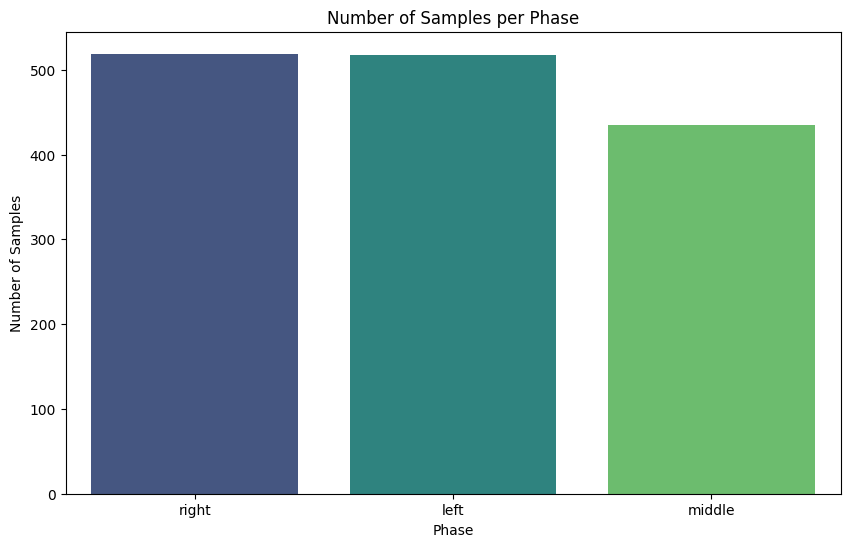

In [115]:
csv_path = 'drive/MyDrive/ski_pose_classifier/gs_training_fps10_sorted_json_scaled_b_b_neck_knee_dist.csv'


df = pd.read_csv(csv_path)
phase_counts = df['phase'].value_counts()


print("Number of samples per phase:")
print(phase_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='viridis')
plt.xlabel('Phase')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Phase')
plt.show()


In [116]:
def calculate_metrics(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1_score_res = f1_score(y_test, y_pred, average='weighted')

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 score:", f1_score_res)

In [117]:
X = df.iloc[:,:-2]
y = df.iloc[:,-2]

img_names = df.iloc[:,-1]


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["left", "middle", "right"])
y = le.transform(y)

indices = np.arange(len(df))

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.15, random_state=1, shuffle=False)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, indices_train, test_size=0.176, random_state=1, shuffle=False)


Accuracy: 0.832579185520362
Precision: 0.8291137828598251
Recall: 0.832579185520362
F1 score: 0.8276936600184321


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


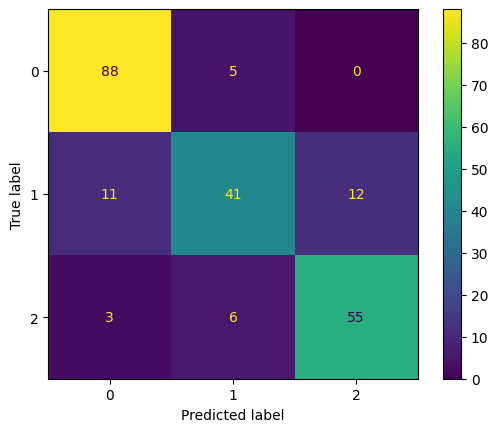

In [118]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
calculate_metrics(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

mlp = MLPClassifier()

param_dist = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

rand_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=5)
rand_search.fit(X_train, y_train)

best_mlp = rand_search.best_estimator_
y_pred = best_mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Best hyperparameters:", rand_search.best_params_)


NameError: name 'X_train' is not defined

Accuracy: 0.8776595744680851
Precision: 0.8828269764346702
Recall: 0.8776595744680851
F1 score: 0.8792437277832158


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


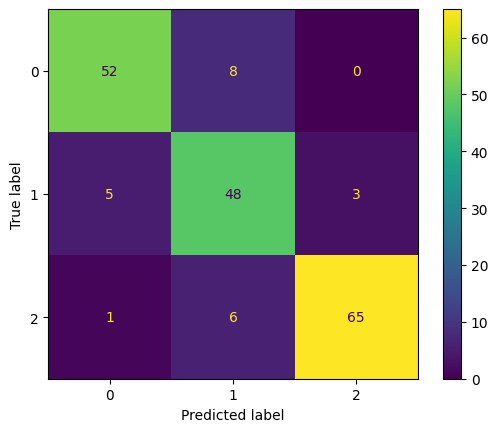

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    learning_rate='adaptive',
    hidden_layer_sizes=(300,),
                    alpha=0.001, random_state=42, activation='relu')
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

calculate_metrics(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

result = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()


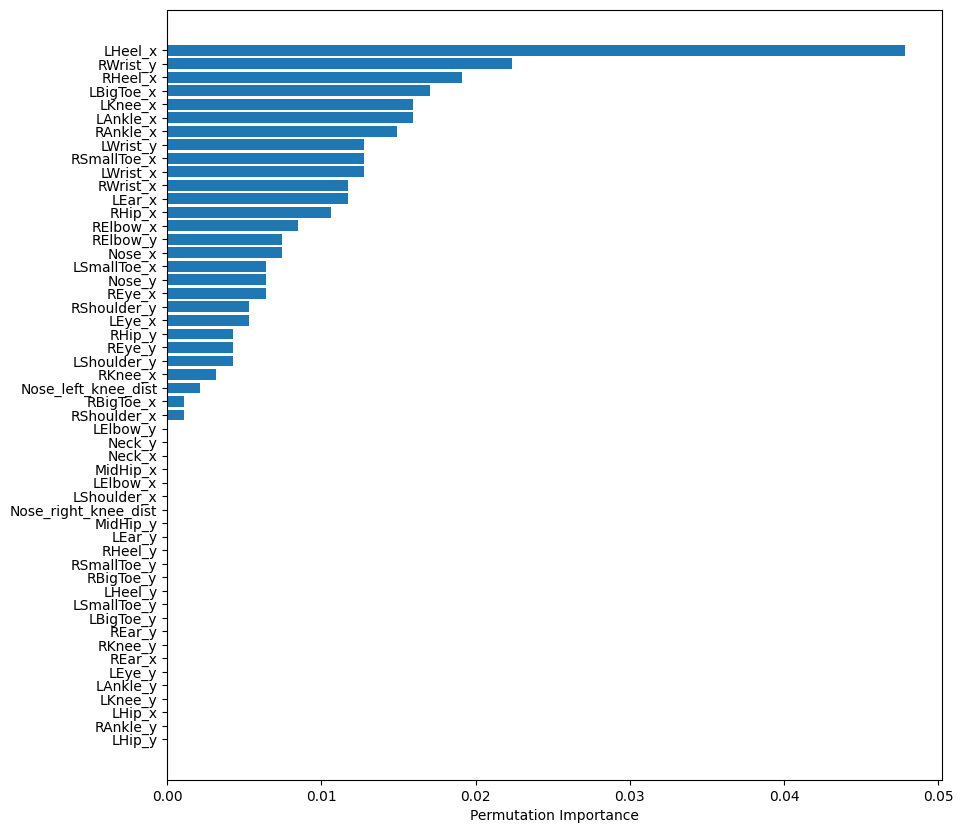

In [ ]:
plt.figure(figsize=(10, 10))

plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [119]:
csv_path = 'drive/MyDrive/ski_pose_classifier/gs_training_fps10_sorted_json_scaled_b_b_neck_knee_dist.csv'

df = pd.read_csv(csv_path)

In [120]:
X = df.iloc[:,:-2]
y = df.iloc[:,-2]

img_names = df.iloc[:,-1]


le = LabelEncoder()
le.fit(["left", "middle", "right"])
y = le.transform(y)

indices = np.arange(len(df))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.15, random_state=1, shuffle=False)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, indices_train, test_size=0.176, random_state=1, shuffle=False)


In [121]:
logits_train = mlp.predict_log_proba(X_train)

In [122]:
logits_val = mlp.predict_log_proba(X_val)

In [123]:
logits_test = mlp.predict_log_proba(X_test)

Number of samples per phase:
phase
right     519
left      517
middle    435
Name: count, dtype: int64


<ipython-input-10-7c89f38bdf88>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["left", "middle", "right"], y=[left_cnt, middle_cnt, right_cnt], palette='viridis')


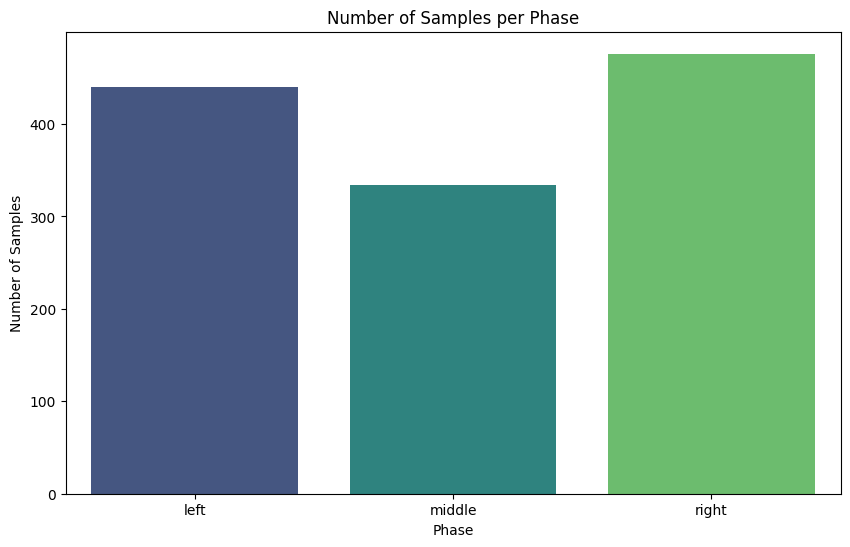

In [10]:
labels  = np.argmax(logits_train, axis=1)
left_cnt = np.sum(labels == 0)
middle_cnt = np.sum(labels == 1)
right_cnt = np.sum(labels == 2)



print("Number of samples per phase:")
print(phase_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=["left", "middle", "right"], y=[left_cnt, middle_cnt, right_cnt], palette='viridis')
plt.xlabel('Phase')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Phase')
plt.show()


In [ ]:
logits_train[26:36]

array([[-3.0336749 , -0.07450171, -3.74415115],
       [-0.02136817, -3.86378055, -8.78518679],
       [-0.07084067, -2.68595063, -8.36312721],
       [-3.28468785, -1.04513661, -0.49281553],
       [-2.99932166, -5.26800422, -0.05654362],
       [-2.03582674, -0.18359323, -3.29270445],
       [-1.41930791, -0.76528747, -1.22786102],
       [-0.06995618, -3.26049749, -3.5337229 ],
       [-0.40200132, -1.27658191, -2.9559184 ],
       [-0.90202648, -0.87339414, -1.73318062]])

In [ ]:
np.array(img_names)

array(['frame_0054', 'frame_0057', 'frame_0059', ..., 'frame_2130',
       'frame_2130', 'frame_2132'], dtype=object)

In [124]:

def create_lstm_dataset(logits, labels, img_names, lookback):
    X, y = [], []
    target_img_names = []
    for i in range(len(logits) - lookback):
        inputs = logits[i : i + lookback]
        target = labels[i + lookback - 1]
        target_img_names.append(img_names[i + lookback])
        X.append(inputs)
        y.append(target)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return torch.tensor(X), torch.tensor(y), target_img_names

features, targets, target_img_names = create_lstm_dataset(logits_train, y_train, img_names, lookback=10)

print("LSTM Input shape:", features.shape)
print("LSTM Target shape:", targets.shape)

LSTM Input shape: torch.Size([1020, 10, 3])
LSTM Target shape: torch.Size([1020])


In [125]:
features_val, targets_val, target_img_names_val = create_lstm_dataset(logits_val, y_val, img_names, lookback=10)

features_test, targets_test, target_img_names_test = create_lstm_dataset(logits_test, y_test, img_names, lookback=10)

In [ ]:
y_train[10:30]

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2])

In [ ]:
targets[:20]

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
        0., 0.])

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [127]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=1, output_dim=3, batch_size=32):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size= self.input_dim ,hidden_size=self.hidden_dim,
                           num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        hidden = self.init_hidden(self.batch_size)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)

        return out
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.num_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.num_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

model = LSTMClassifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [128]:
from torch.utils.data import Dataset, DataLoader
class StringDataset(Dataset):
    def __init__(self, string_list):
        self.string_list = string_list

    def __len__(self):
        return len(self.string_list)

    def __getitem__(self, idx):
        return self.string_list[idx]


img_names_dataset = StringDataset(target_img_names_test)


In [39]:
y_train

array([2, 2, 2, ..., 0, 0, 0])

In [129]:
batch_size = 32
train_loader = DataLoader(data.TensorDataset(features, targets), shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(data.TensorDataset(features_val, targets_val), shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(data.TensorDataset(features_test, targets_test), shuffle=False, batch_size=batch_size, drop_last=True)
img_names_loader = DataLoader(img_names_dataset, batch_size=batch_size, shuffle=False)


In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
epochs = 100


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_correct, train_total = 0, 0
    val_logits = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        total_train_loss += loss.item()

        pred_classes = preds.argmax(dim=1)
        train_correct += (pred_classes == labels).sum().item()
        train_total += labels.numel()

        optimizer.step()

    train_loss = total_train_loss / train_total
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    total_val_loss = 0
    val_correct, val_total = 0, 0
    all_preds = []
    all_labels = []
    batch_num = 0
    with torch.no_grad():
        for val_data in val_loader:

          inputs, val_labels = val_data[0], val_data[1]
          inputs, val_labels = inputs.to(device).float(), val_labels.to(device).long()
          val_preds = model(inputs)

          val_loss = criterion(val_preds, val_labels)
          total_val_loss += val_loss.item()

          val_logits.append(val_preds)
          pred_classes = val_preds.argmax(dim=1)
          val_correct += (pred_classes == val_labels).sum().item()
          val_total += val_labels.numel()
          all_preds.extend(pred_classes.cpu().numpy())
          all_labels.extend(val_labels.cpu().numpy())

          batch_num += 1


    val_loss = total_val_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")
    print("=" * 40)


Epoch 1/100
Train Loss: 0.0326, Train Accuracy: 61.09%
Val Loss: 0.0313, Val Accuracy: 71.88%
Epoch 2/100
Train Loss: 0.0292, Train Accuracy: 73.59%
Val Loss: 0.0287, Val Accuracy: 70.09%
Epoch 3/100
Train Loss: 0.0262, Train Accuracy: 72.08%
Val Loss: 0.0263, Val Accuracy: 69.20%
Epoch 4/100
Train Loss: 0.0235, Train Accuracy: 72.68%
Val Loss: 0.0243, Val Accuracy: 70.09%
Epoch 5/100
Train Loss: 0.0212, Train Accuracy: 74.70%
Val Loss: 0.0225, Val Accuracy: 71.43%
Epoch 6/100
Train Loss: 0.0192, Train Accuracy: 77.32%
Val Loss: 0.0206, Val Accuracy: 73.66%
Epoch 7/100
Train Loss: 0.0172, Train Accuracy: 80.44%
Val Loss: 0.0189, Val Accuracy: 75.45%
Epoch 8/100
Train Loss: 0.0154, Train Accuracy: 82.36%
Val Loss: 0.0174, Val Accuracy: 77.23%
Epoch 9/100
Train Loss: 0.0139, Train Accuracy: 83.87%
Val Loss: 0.0163, Val Accuracy: 79.91%
Epoch 10/100
Train Loss: 0.0128, Train Accuracy: 85.28%
Val Loss: 0.0153, Val Accuracy: 82.14%
Epoch 11/100
Train Loss: 0.0120, Train Accuracy: 86.19%
Val

In [130]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
epochs = 50


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_correct, train_total = 0, 0
    val_logits = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        total_train_loss += loss.item()

        pred_classes = preds.argmax(dim=1)
        train_correct += (pred_classes == labels).sum().item()
        train_total += labels.numel()

        optimizer.step()

    train_loss = total_train_loss / train_total
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    total_val_loss = 0
    val_correct, val_total = 0, 0
    all_preds = []
    all_labels = []
    batch_num = 0
    with torch.no_grad():
        for val_data in val_loader:

          inputs, val_labels = val_data[0], val_data[1]
          inputs, val_labels = inputs.to(device).float(), val_labels.to(device).long()
          val_preds = model(inputs)

          val_loss = criterion(val_preds, val_labels)
          total_val_loss += val_loss.item()

          val_logits.append(val_preds)
          pred_classes = val_preds.argmax(dim=1)
          val_correct += (pred_classes == val_labels).sum().item()
          val_total += val_labels.numel()
          all_preds.extend(pred_classes.cpu().numpy())
          all_labels.extend(val_labels.cpu().numpy())

          batch_num += 1


    val_loss = total_val_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")
    print("=" * 40)


Epoch 1/50
Train Loss: 0.0322, Train Accuracy: 54.74%
Val Loss: 0.0309, Val Accuracy: 65.62%
Epoch 2/50
Train Loss: 0.0295, Train Accuracy: 66.83%
Val Loss: 0.0283, Val Accuracy: 65.62%
Epoch 3/50
Train Loss: 0.0270, Train Accuracy: 67.94%
Val Loss: 0.0258, Val Accuracy: 64.58%
Epoch 4/50
Train Loss: 0.0246, Train Accuracy: 68.04%
Val Loss: 0.0235, Val Accuracy: 66.67%
Epoch 5/50
Train Loss: 0.0225, Train Accuracy: 69.76%
Val Loss: 0.0214, Val Accuracy: 71.35%
Epoch 6/50
Train Loss: 0.0201, Train Accuracy: 76.21%
Val Loss: 0.0192, Val Accuracy: 77.08%
Epoch 7/50
Train Loss: 0.0182, Train Accuracy: 79.13%
Val Loss: 0.0172, Val Accuracy: 80.73%
Epoch 8/50
Train Loss: 0.0163, Train Accuracy: 81.75%
Val Loss: 0.0155, Val Accuracy: 82.81%
Epoch 9/50
Train Loss: 0.0148, Train Accuracy: 84.27%
Val Loss: 0.0144, Val Accuracy: 84.90%
Epoch 10/50
Train Loss: 0.0139, Train Accuracy: 85.58%
Val Loss: 0.0136, Val Accuracy: 84.90%
Epoch 11/50
Train Loss: 0.0128, Train Accuracy: 86.69%
Val Loss: 0.01

In [54]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple

def predict_lstm_turn_phases(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device
) -> Tuple[List[str], Dict[str, List[List[str]]], np.ndarray]:

    criterion = nn.CrossEntropyLoss()
    model.eval()
    all_probs_batches = []
    total_train_loss = 0 # todo rename
    train_correct, train_total = 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            logits = model(inputs)

            loss = criterion(logits, labels)
            total_train_loss += loss.item()


            pred_classes = logits.argmax(dim=1)
            train_correct += (pred_classes == labels).sum().item()
            train_total += labels.numel()
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs_batches.append(probs)

    train_loss = total_train_loss / train_total
    train_accuracy = train_correct / train_total

    print("test loss ", train_loss)
    print("test accuracy ", train_accuracy)

In [56]:
predict_lstm_turn_phases(model,
                             test_loader,
                             device)

test loss  0.012753661954775453
test accuracy  0.8645833333333334


In [132]:
predict_lstm_turn_phases(model,
                             test_loader,
                             device)

test loss  0.011302315164357424
test accuracy  0.8697916666666666


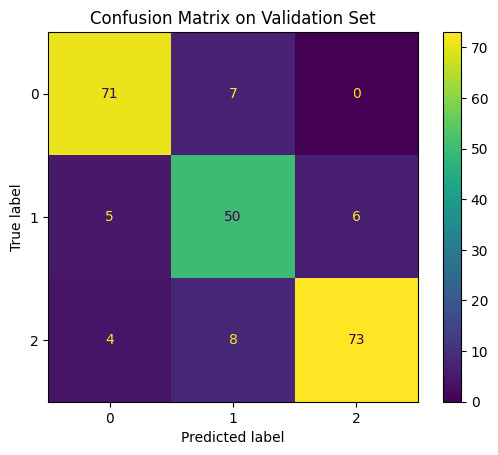

In [25]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()


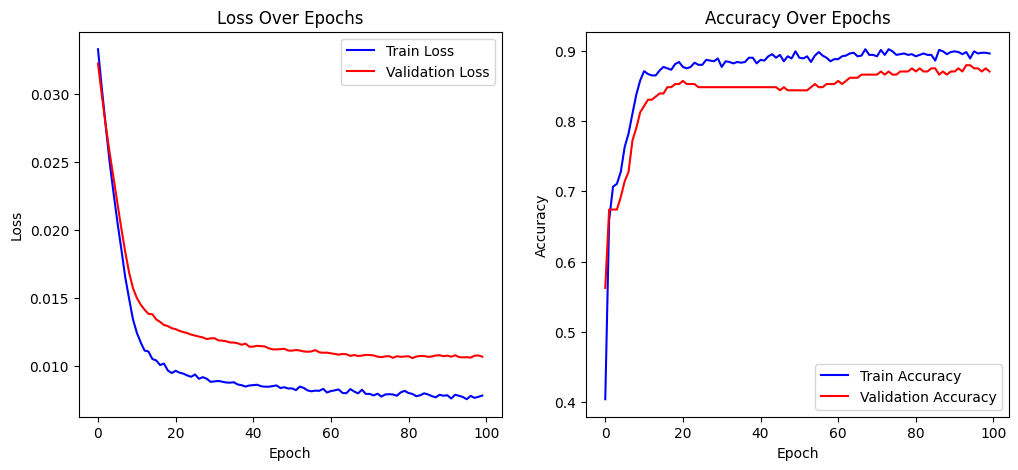

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='blue')
plt.plot(val_accuracies, label="Validation Accuracy", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.show()


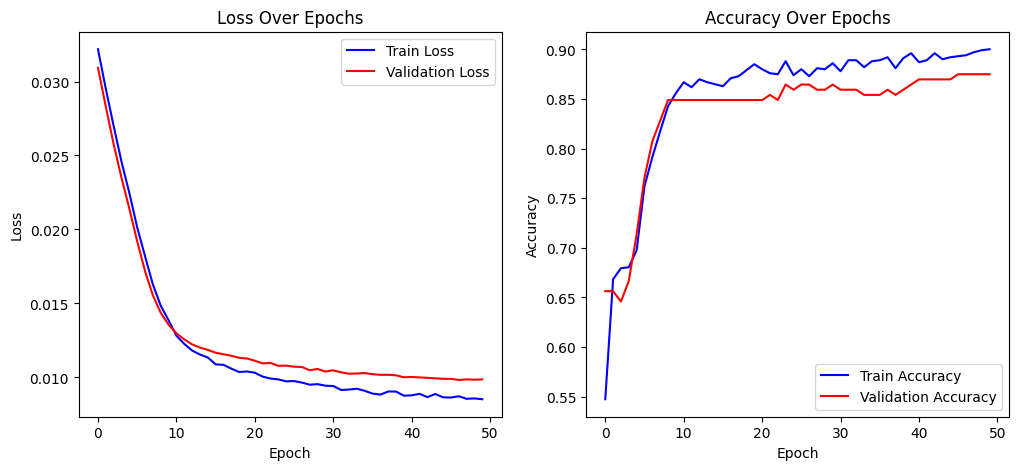

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='blue')
plt.plot(val_accuracies, label="Validation Accuracy", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.show()


In [ ]:
flattened_tensor = torch.cat(val_logits, dim=0)
flattened_np = flattened_tensor.numpy()
flattened_np

array([[-8.23988676e-01,  8.21578324e-01, -6.93413913e-02],
       [-2.09214874e-02, -2.63014436e-01, -3.86814326e-01],
       [ 1.29117072e+00, -9.47815180e-01, -1.03838408e+00],
       [ 2.28690886e+00, -1.06739140e+00, -1.82103539e+00],
       [ 3.03498530e+00, -1.41590786e+00, -2.23753691e+00],
       [ 2.60582900e+00, -4.14105266e-01, -2.55630422e+00],
       [ 8.96774590e-01,  1.38925791e+00, -2.27855325e+00],
       [-1.43942797e+00,  2.75527668e+00, -1.07243025e+00],
       [-3.17493415e+00,  2.29385424e+00,  1.23831856e+00],
       [-3.64046192e+00,  1.67626381e+00,  2.31980348e+00],
       [-3.64913082e+00,  8.24586093e-01,  3.27164197e+00],
       [-3.50135922e+00,  3.65555227e-01,  3.61347985e+00],
       [-3.06428313e+00, -3.14788997e-01,  3.92363548e+00],
       [-2.77656150e+00, -3.97073269e-01,  3.63551497e+00],
       [-2.64335585e+00, -2.99361236e-02,  2.93610024e+00],
       [-2.47231889e+00,  7.57617056e-01,  1.58762062e+00],
       [-2.19416785e+00,  1.49567842e+00

Number of samples per phase:
phase
right     519
left      517
middle    435
Name: count, dtype: int64


<ipython-input-67-d0449442c643>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["left", "middle", "right"], y=[left_cnt, middle_cnt, right_cnt], palette='viridis')


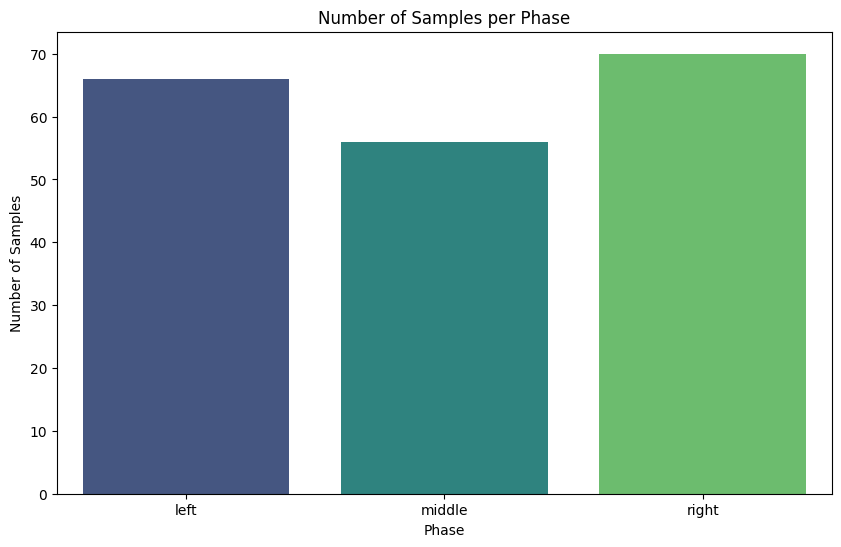

In [ ]:
labels = np.argmax(flattened_np, axis=1)

left_cnt = np.sum(labels == 0)
middle_cnt = np.sum(labels == 1)
right_cnt = np.sum(labels == 2)






print("Number of samples per phase:")
print(phase_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=["left", "middle", "right"], y=[left_cnt, middle_cnt, right_cnt], palette='viridis')
plt.xlabel('Phase')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Phase')
plt.show()